In [3]:
import pandas as pd

from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('application_train.csv')

## Предобработка данных 

In [5]:
mis_val_percent = (100 * pd.isnull(df).sum() / len(df)).sort_values(ascending = False)[:15]

In [6]:
for col in mis_val_percent.index:
    if(mis_val_percent[col] > 80):
        del df[col]

In [7]:
y = df['TARGET']

del df['TARGET']
del df['SK_ID_CURR']

In [8]:
num_cols = df.select_dtypes(exclude = ["object"]).columns
categ_cols = df.select_dtypes(include = ["object"]).columns

In [9]:
for col in num_cols:
    df[col] = df[col].fillna(df[col].mean())

In [10]:
for col in categ_cols:
    df[col] =df[col].fillna('None')

## Кодирование

In [11]:
df = pd.get_dummies(df)

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
def encoder(df):
    scaler = MinMaxScaler()
    numerical = df.select_dtypes(exclude = ["object"]).columns
    features_transform = pd.DataFrame(data= df)
    features_transform[numerical] = scaler.fit_transform(df[numerical])
    display(features_transform.head(n = 5))
    return df

df_scaled = encoder(df)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_None,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_None,EMERGENCYSTATE_MODE_Yes
0,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.888839,0.045086,0.852140,0.705433,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.477114,0.043648,0.951929,0.959566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,0.348534,0.046161,0.827335,0.648326,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,0.350846,0.038817,0.601451,0.661387,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,0.298591,0.038820,0.825268,0.519522,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Моделирование

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

In [15]:
from xgboost import XGBClassifier, plot_importance

In [16]:
fit = XGBClassifier().fit(df_scaled, y)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

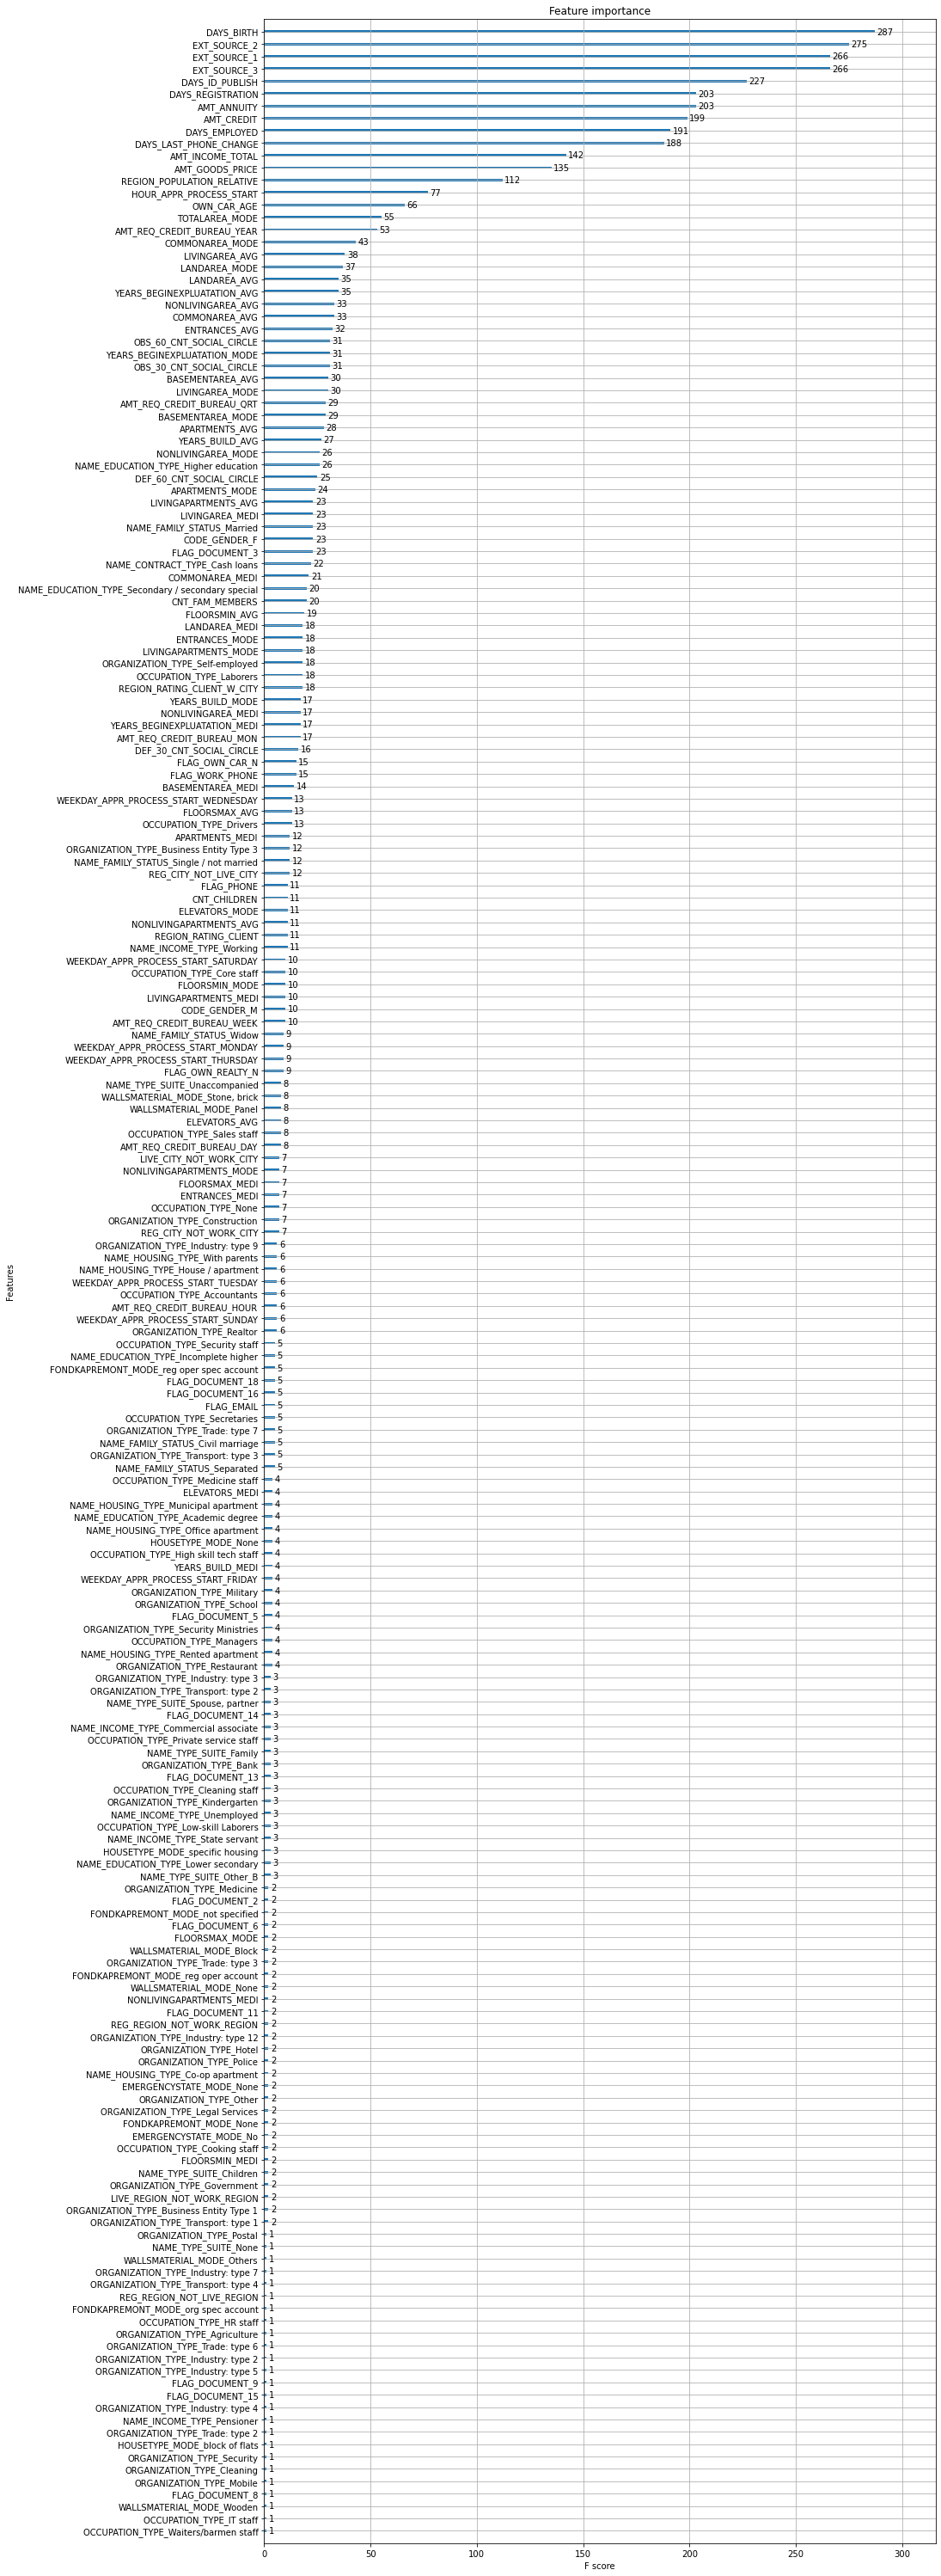

In [17]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 54)
plot_importance(fit)

In [18]:
mdict = fit.get_booster().get_score()

In [19]:
best_features = sorted(mdict, key=mdict.get, reverse=True)[0:30]

In [20]:
df = pd.DataFrame(df_scaled[best_features])

In [21]:
df.shape

(307511, 30)

#### Глубина дерева

In [47]:
max_depth = []
x = []

for i in [2, 3, 5, 10, 15, 20, 30]:
    clf = XGBClassifier(random_state=0, max_depth = i)
    scores = cross_val_score(clf, df, y, cv=3, scoring='roc_auc')
    max_depth.append(scores.mean())
    x.append(i)

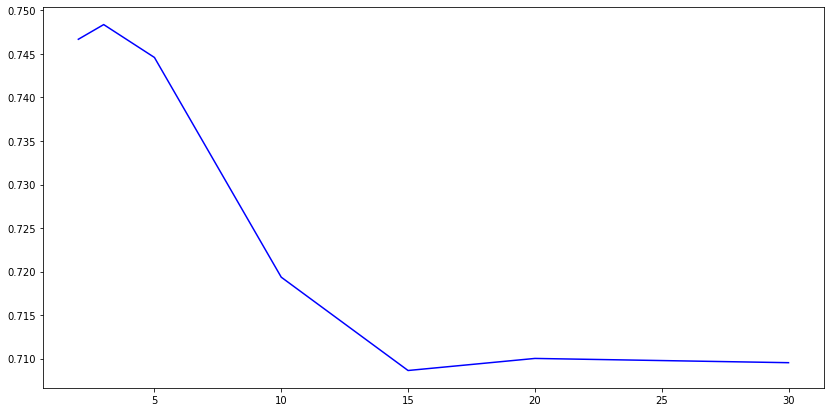

In [58]:
plt.rcParams["figure.figsize"] = (14, 7)
plt.plot(x, max_depth, 'b')

#### min_samples_split

In [64]:
n_estimators = []
x_n_estimators= []

for i in [20, 30, 40, 50, 60]:
    clf = XGBClassifier(random_state=0, n_estimators = i)
    scores = cross_val_score(clf, df, y, cv=3, scoring='roc_auc')
    n_estimators.append(scores.mean())
    x_n_estimators.append(i)

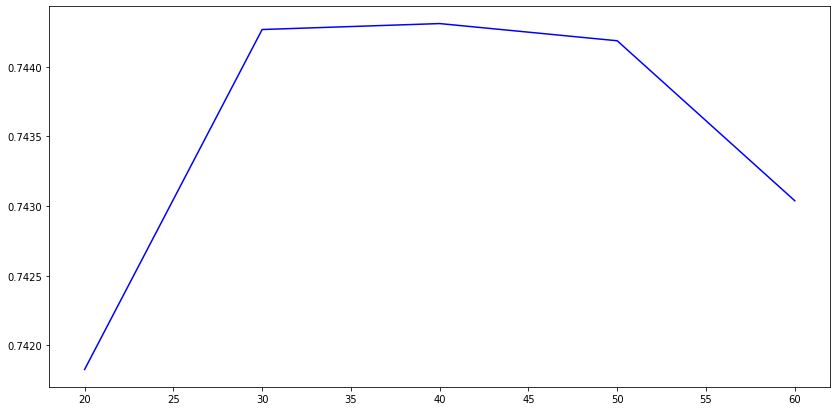

In [65]:
plt.rcParams["figure.figsize"] = (14, 7)

plt.plot(x_n_estimators, n_estimators, 'b')

#### min_samples_leaf

In [77]:
learning_rate = []
x_learning_rate = []

for i in [0.005, 0.01, 0.1, 0.15, 0.2]:
    clf = XGBClassifier(random_state=0, learning_rate = i)
    scores = cross_val_score(clf, df, y, cv=3, scoring='roc_auc')
    learning_rate.append(scores.mean())
    x_learning_rate.append(i)

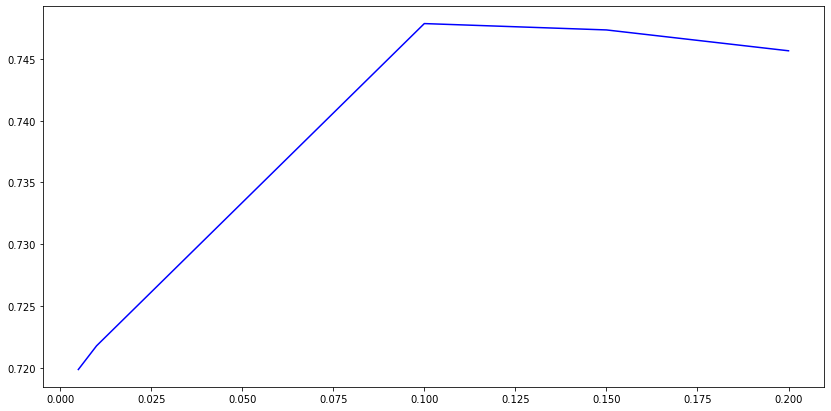

In [78]:
plt.rcParams["figure.figsize"] = (14, 7)

plt.plot(x_learning_rate, learning_rate, 'b')

## GridSearch

In [22]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [30, 35, 38],
     'importance_type': ['gain', 'weight', 'cover', 'total_gain'],
}

clf = GridSearchCV(XGBClassifier(), parameters, scoring='roc_auc').fit(df, y)

In [23]:
clf.best_score_

0.7463008229827283

In [24]:
clf.best_params_

{'importance_type': 'gain', 'n_estimators': 35}